# Denoising Noise in Thermal Video as Sequence of Images

In [ ]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
from models import get_net
import torch
import torch.optim
# from skimage.measure import compare_psnr
from skimage.metrics import peak_signal_noise_ratio
from util.common_utils import * 
from util.loss import total_variation

if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark =True
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor

PLOT = True
imsize=-1
dim_div_by = 64

## Load Video as Frames

Picture Size: (1, 256, 320)
Video Length: 200


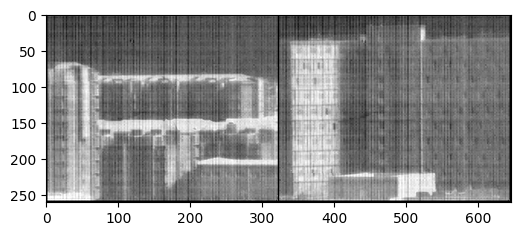

In [16]:
import cv2

# Define the video file path 
video_file = os.path.join(os.getcwd(), 'data','building','RAW.avi')
if not os.path.exists(video_file):
    raise FileNotFoundError(f"Video file not found: {video_file}")

img_np_list = []
img_gpu_list = []

cap = cv2.VideoCapture(video_file)

while (cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        img_np = frame[..., 0]
        img_np = np.expand_dims(img_np, 0)
        img_np = np.array(img_np, dtype=np.float32) / 255.0
        img_np_list.append(img_np)
        img_gpu_list.append(np_to_torch(img_np).type(dtype))
    else:
        break
# size of each frame
print("Picture Size:", img_np_list[0].shape)
# length of video as picture frames
print("Video Length:", len(img_np_list))
# show two frames
_ = plot_image_grid([img_np_list[0], img_np_list[-1]], factor=4, nrow=2)

## Train-Test Split of the Video

In [ ]:
train_frac = 0.2  # Use 20% picture for training
test_frac = 1 - train_frac

num_train = int(len(img_np_list) * train_frac)
print("total number of training image:", num_train)
train_index = np.random.choice(range(len(img_np_list)), num_train, replace=False)
print(train_index)

total number of training image: 40
[ 71  17  10  93 196  97 162 117 172 114  15  48 180  53  27 166  38  66
  65 147  74  45 121  33   8  91 190  76 109 163 184  96 183 129 165 111
  52 107 136 134]


## 2. General Model Setup

In [32]:
# Hyperparameters
show_every=1200
figsize=5
pad = 'reflection' # 'zero'
INPUT = 'noise'
input_depth = 32
OPTIMIZER = 'adam'
OPT_OVER =  'net'
LR = 1e-3
num_iter = 18000
iter_step = 1500

reg_noise_std = 3e-5

# Initialize Network
NET_TYPE = 'skip'
net = get_net(input_depth, 'skip', pad, n_channels=1,
              skip_n33d=128, 
              skip_n33u=128, 
              skip_n11=4, 
              num_scales=5,
              upsample_mode='bilinear').type(dtype)

# Loss
mse = torch.nn.MSELoss().type(dtype)
#img_var = np_to_torch(img_np).type(dtype)

net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype).detach()

### Model Train with a predefined epochs

Starting optimization with ADAM


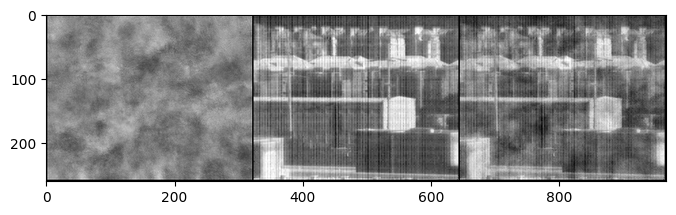

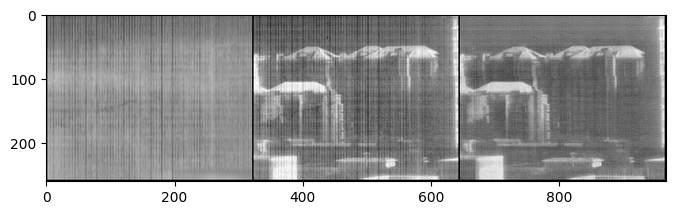

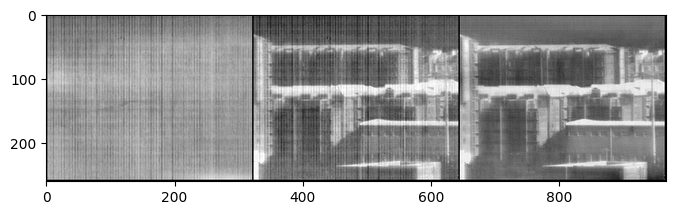

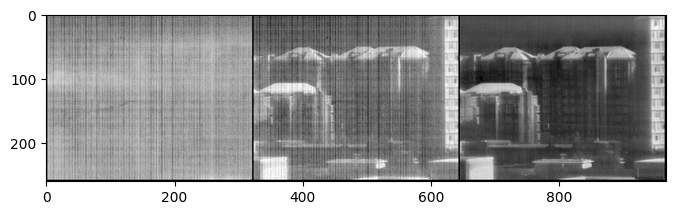

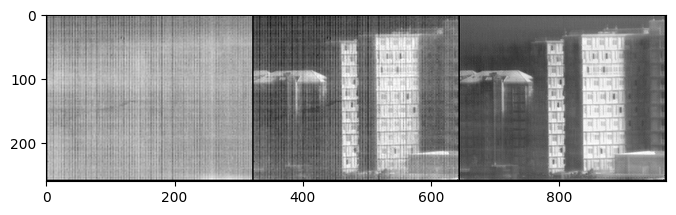

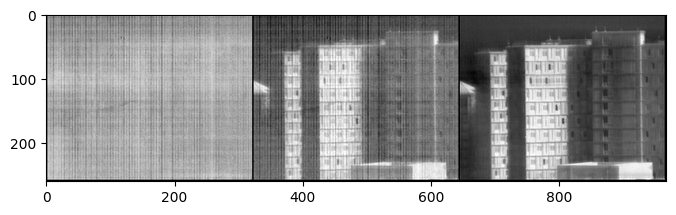

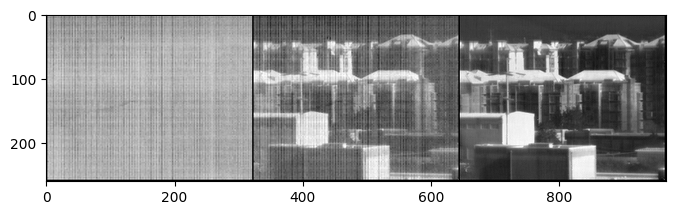

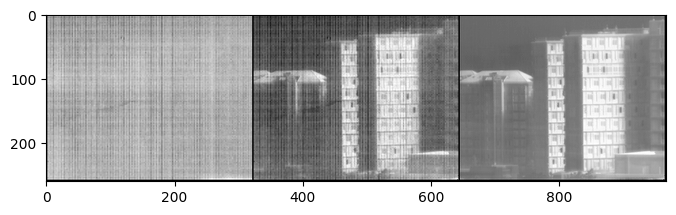

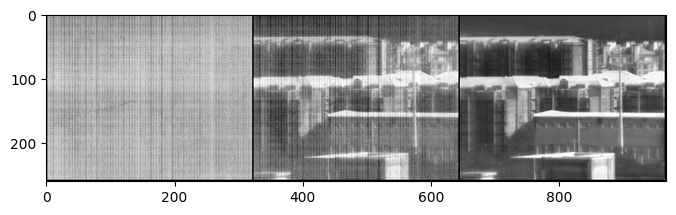

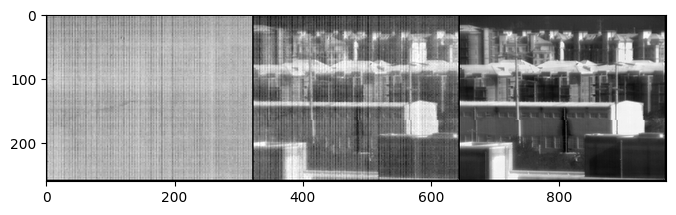

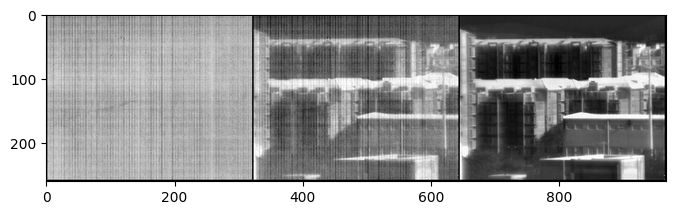

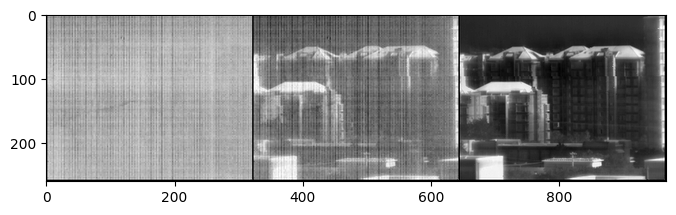

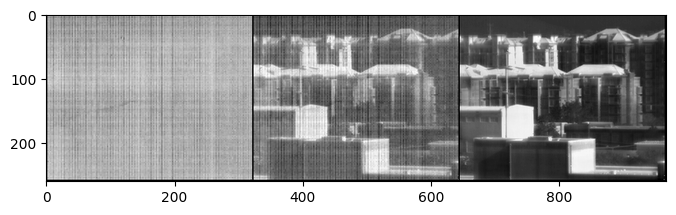

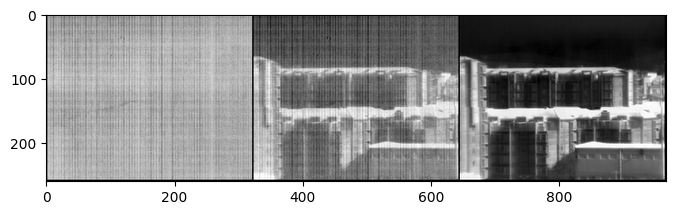

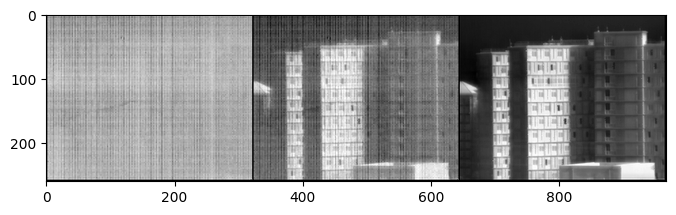

In [33]:
def closure():
    global i, last_net, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)

    index = np.random.choice(train_index, size=1)[0]

    target = img_np_list[index]
    target_gpu = img_gpu_list[index]


    if i <= iter_step * 1:
        tv_step = np.random.randint(50, 60)
    elif i <= iter_step * 2:
        tv_step = np.random.randint(40, 50)
    elif i <= iter_step * 3:
        tv_step = np.random.randint(30, 40)
    elif i <= iter_step * 4:
        tv_step = np.random.randint(20, 30)
    elif i <= iter_step * 5:
        tv_step = np.random.randint(10, 20)
    elif i <= iter_step * 6:
        tv_step = np.random.randint(3, 10)
    else:
        tv_step = 1
    
    total_loss = total_variation(img_gpu_list[index] - out, reduction="sum", step=tv_step) #+ 1e-1 * mse(fpn_target, out)
    
    total_loss.backward()

    learned_noise = out.detach().cpu().numpy()[0]
    out_clean = img_np_list[index] - out.detach().cpu().numpy()[0]
    out_clean_norm = (out_clean-np.min(out_clean))/(np.max(out_clean)-np.min(out_clean))
    psrn = peak_signal_noise_ratio(img_np_list[index], out_clean_norm) 

    print ('Iteration %05d    Loss %f PSNR %f' % (i, total_loss.item(), psrn),'\r', end='')
    
    if  PLOT and i % show_every == 0:
        plot_image_grid([np.clip(learned_noise, 0, 1), target, out_clean_norm], factor=figsize, nrow=3)

    i += 1
    return total_loss

# Init globals 
last_net = None
i = 0

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

# Run
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR=LR, num_iter=num_iter)

In [36]:
# Save Denoised Video
out_np = torch_to_np(net(net_input))
out_list = [(img - out_np[0]) for img in img_np_list]

normalized_frames = [
    ((frame - np.min(frame)) / (np.max(frame) - np.min(frame) + 1e-8) * 255).astype(np.uint8)[0]
    for frame in out_list
]

# Extract frame dimensions
frame_width = normalized_frames[0].shape[1]
frame_height = normalized_frames[0].shape[0]

# Initialize VideoWriter: output filename, codec, FPS, frame size, grayscale
out_video = cv2.VideoWriter('denoised_output.avi', cv2.VideoWriter_fourcc(*'MJPG'), 5, (frame_width, frame_height), isColor=False)

# Write all frames
for frame in normalized_frames:
    out_video.write(frame)

out_video.release()
print("✅ Video saved as 'denoised_output.avi'")
cv2.destroyAllWindows()

✅ Video saved as 'denoised_output.avi'
